# Compare all the versions of AVHRR NDVI to MODIS

and then compare their anomalies with Landsat anomalies

In [1]:
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
import geopandas as gpd
from scipy import stats
import xskillscore as xs
import contextily as ctx
import matplotlib as mpl
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from scipy.stats import gaussian_kde
from matplotlib.cm import ScalarMappable
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import FormatStrFormatter

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

## Analysis Parameters

In [2]:
model_var='NDVI'
crs='epsg:4326'
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

## Open datasets

In [3]:
avhrr = xr.open_dataset(base+model_var+'_harmonization/AVHRR_'+model_var+'_5km_monthly_1982_2013.nc')[model_var+'_avhrr']
avhrr = assign_crs(avhrr, crs=crs)
avhrr.attrs['nodata'] = np.nan

modis = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
modis = assign_crs(modis, crs=crs)
modis.attrs['nodata'] = np.nan

gimms_pku = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS-PKU_1982_2013.nc').rename({'__xarray_dataarray_variable__':'NDVI'})['NDVI']
gimms_pku = assign_crs(gimms_pku, crs=crs)
gimms_pku.attrs['nodata'] = np.nan

gimms_pku_cons = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc').rename({'__xarray_dataarray_variable__':'NDVI'})['NDVI']
gimms_pku_cons = gimms_pku_cons.sel(time=slice('1982','2013'))
gimms_pku_cons = assign_crs(gimms_pku_cons, crs=crs)
gimms_pku_cons.attrs['nodata'] = np.nan

gimms = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS3g_v1.1_1982_2013.nc')['NDVI']
gimms = assign_crs(gimms, crs='epsg:3577')
gimms.attrs['nodata'] = np.nan

# trees = xr.open_dataset(f'{base}NDVI_harmonization/LGBM/NDVI_trees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
# nontrees = xr.open_dataset(f'{base}/NDVI_harmonization/LGBM/NDVI_nontrees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
# merge = xr.where(np.isnan(trees), nontrees, trees)
# merge = assign_crs(merge, crs=crs)
# merge.attrs['nodata'] = np.nan
# merge = merge.rename('NDVI')

# avhrr_mask =  ~np.isnan(merge)
# del avhrr_mask.attrs['nodata']
# avhrr_mask = assign_crs(avhrr_mask, crs=crs)


## Resample datasets to match GIMMS

In [4]:
avhrr = avhrr.sel(time=slice('1982', '2013'))
gimms_pku = gimms_pku.sel(time=slice('1982', '2013'))
gimms_pku_cons = gimms_pku_cons.sel(time=slice('1982', '2013'))
gimms = gimms.sel(time=slice('1982', '2013'))
# merge = merge.sel(time=slice('2001', '2013'))
# modis = modis.sel(time=slice('1982', '2013'))

avhrr = avhrr.odc.reproject(gimms_pku.odc.geobox, resampling='average')
avhrr = round_coords(avhrr)

gimms_pku_cons = gimms_pku_cons.odc.reproject(gimms_pku.odc.geobox, resampling='nearest')
gimms_pku_cons = round_coords(gimms_pku_cons)

gimms = gimms.odc.reproject(gimms_pku.odc.geobox, resampling='nearest')
gimms = round_coords(gimms)
gimms_pku = round_coords(gimms_pku)

modis = modis.odc.reproject(gimms_pku.odc.geobox, resampling='average')
modis = round_coords(modis)

# merge = merge.odc.reproject(gimms_pku.odc.geobox, resampling='average')
# merge = round_coords(merge)

In [5]:
gimms_pku = round_coords(gimms_pku)

In [6]:
gimms_mask =  ~np.isnan(gimms)
del gimms_mask.attrs['nodata']
gimms_mask = assign_crs(gimms_mask, crs=crs)

gimms_mask_cons =  ~np.isnan(gimms_pku_cons)
del gimms_mask_cons.attrs['nodata']
gimms_mask_cons = assign_crs(gimms_mask_cons, crs=crs)

cdr_mask =  ~np.isnan(avhrr)
del cdr_mask.attrs['nodata']
cdr_mask = assign_crs(cdr_mask, crs=crs)

pku_mask =  ~np.isnan(gimms_pku)
del pku_mask.attrs['nodata']
pku_mask = assign_crs(pku_mask, crs=crs)

#combine masks
mask = (gimms_mask & cdr_mask & pku_mask & gimms_mask_cons)

In [7]:
gimms_pku = gimms_pku.where(mask)
gimms = gimms.where(mask)
avhrr = avhrr.where(mask)
gimms_pku_cons = gimms_pku_cons.where(mask)
# modis = modis.where(mask)

### Timeseries plots


#### per region

In [8]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

In [9]:
roll=12

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


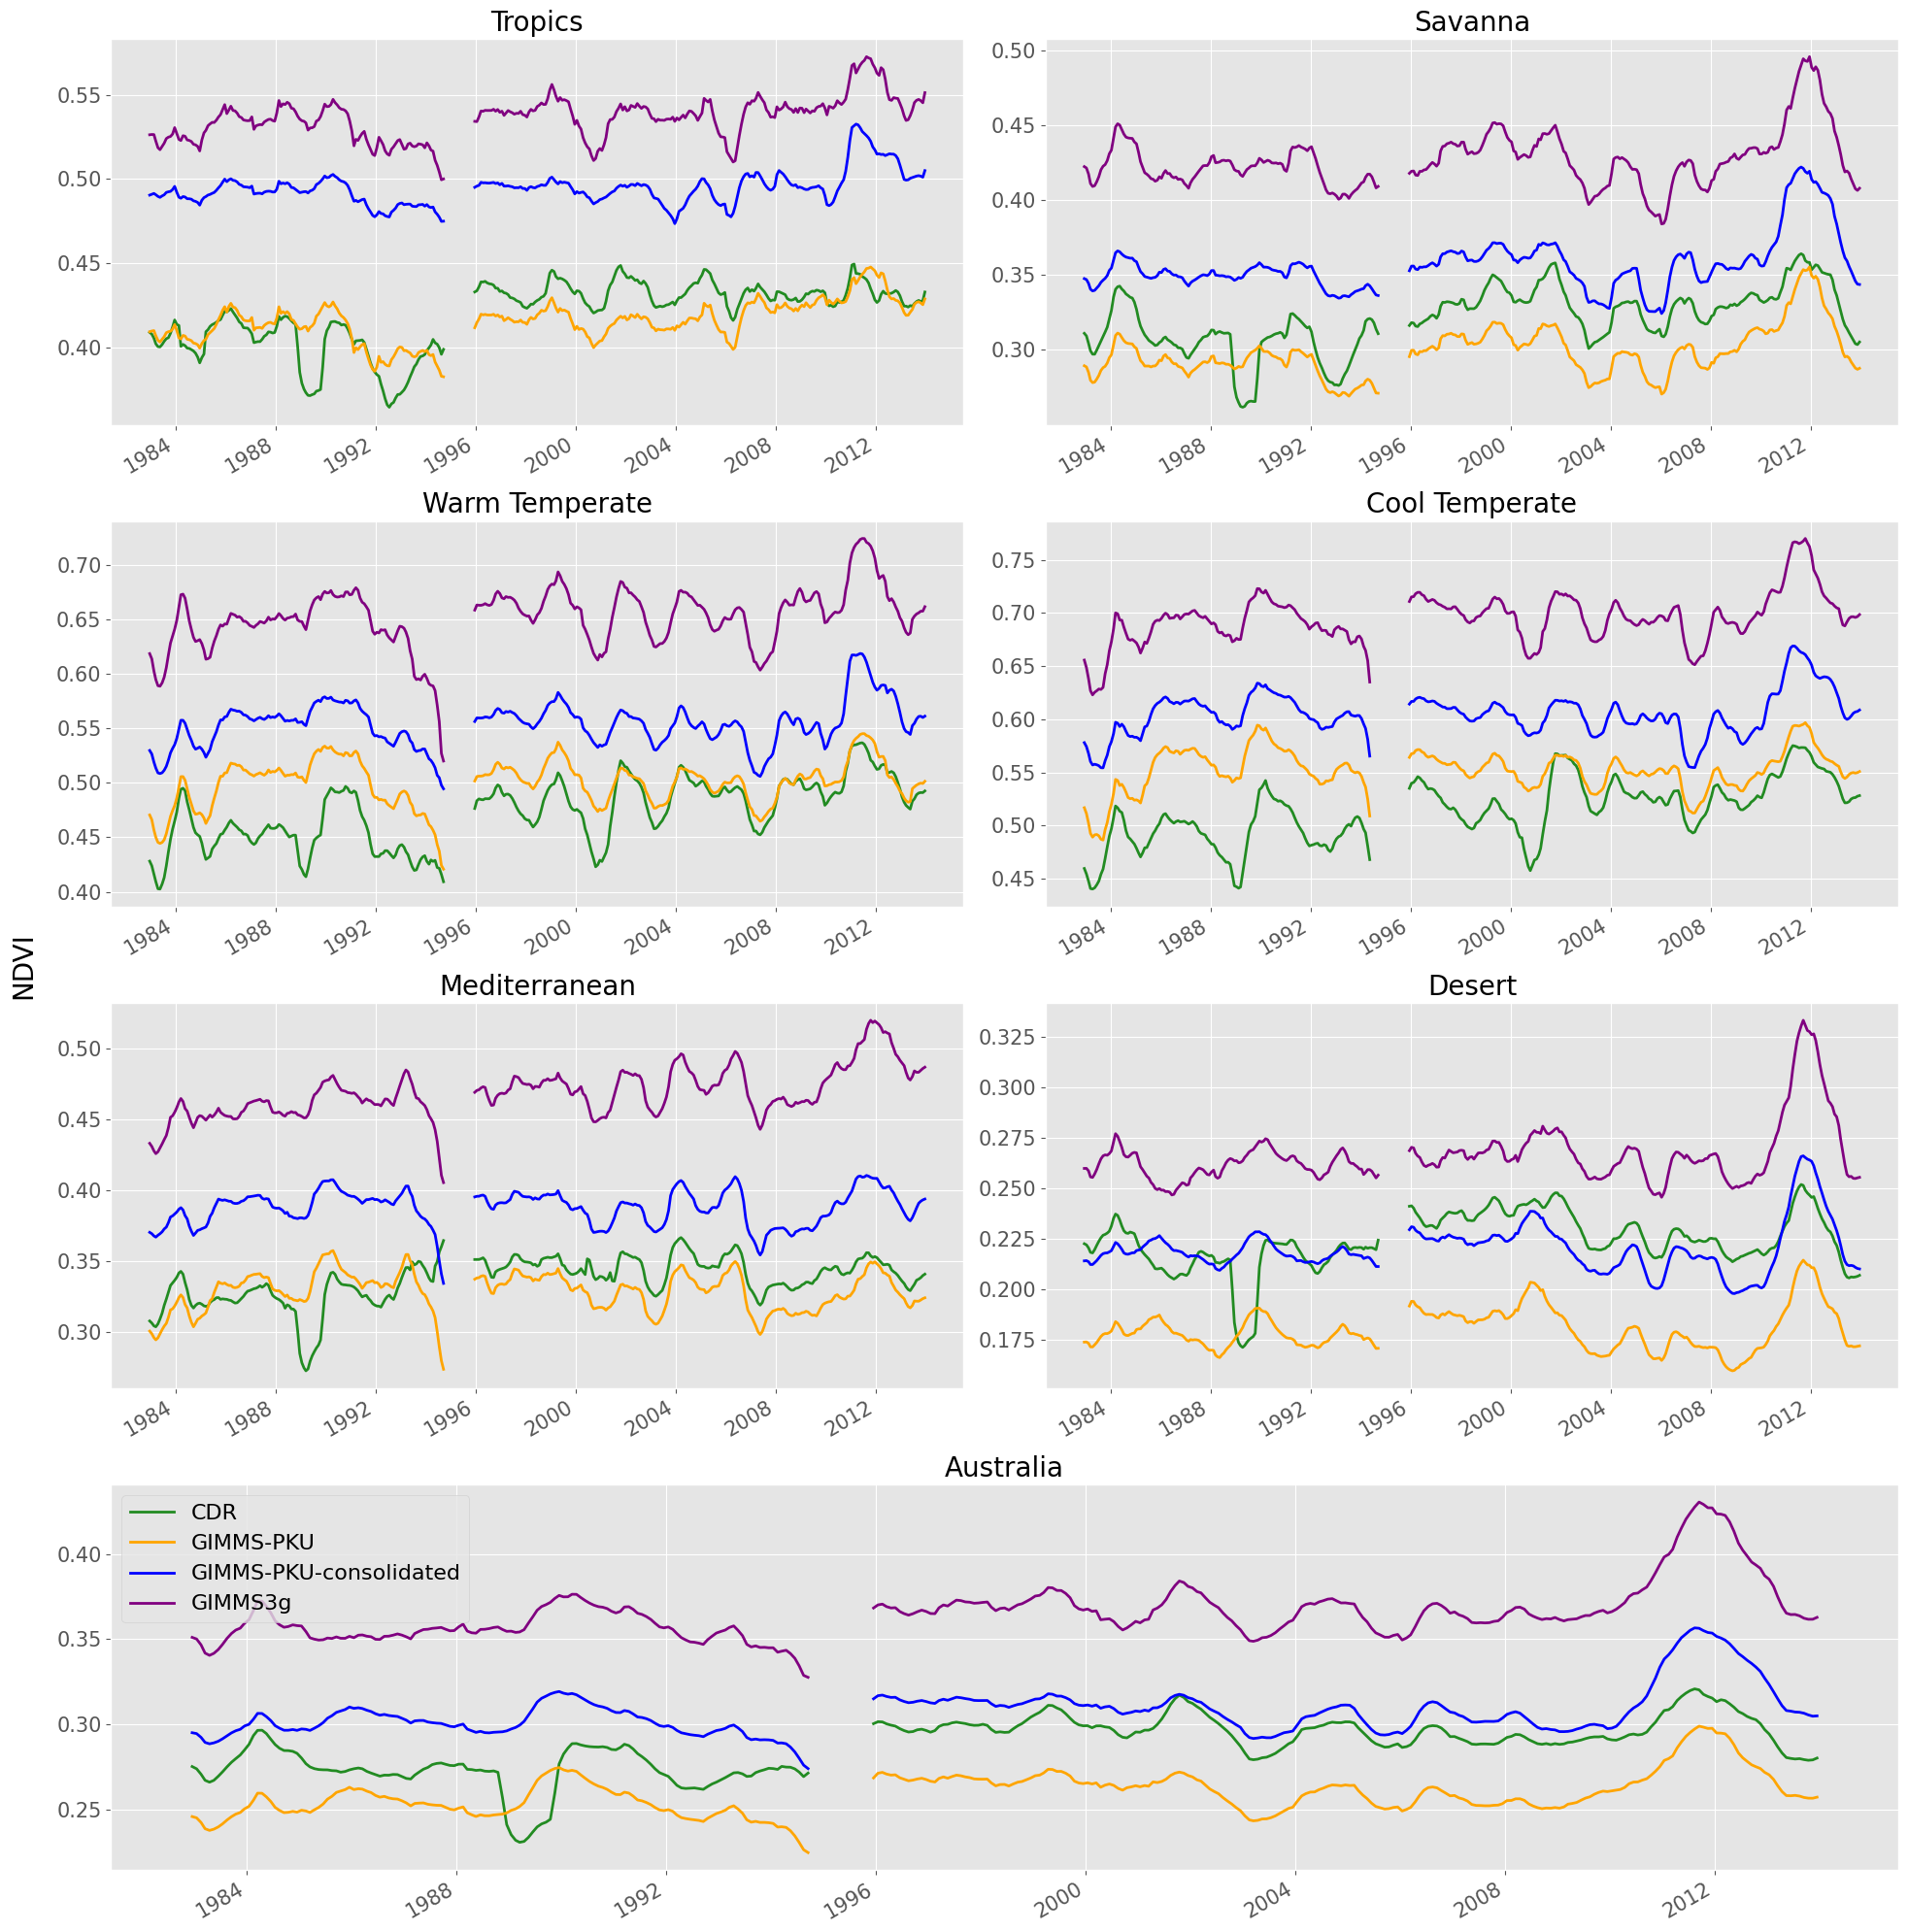

In [10]:
mosiac = [
    ["A", "B"],
    ["C", "D"],
    ["E", "F"],
    ["G", "G"],
]

fig, axes = plt.subplot_mosaic(mosiac, figsize=(20,20))

for ax, (index, row) in zip(axes, gdf.iterrows()):
    print(row['region_name'])
    # Generate a polygon mask to keep only data within the polygon
    m = xr_rasterize(gdf.iloc[[index]], gimms_pku, crs=crs)
    m = round_coords(m)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    # modis_region = modis.where(mask)
    avhrr_region = avhrr.where(m)
    #merge_region = merge.where(mask)
    gimms_pku_region = gimms_pku.where(m)
    gimms_pku_cons_region = gimms_pku_cons.where(m)
    gimms_region = gimms.where(m)

    avhrr_region.mean(['latitude','longitude']).rolling(time=roll, min_periods=roll).mean().plot(ax=axes[ax], label='ACDR', c ='forestgreen', linewidth=2)
    gimms_pku_region.mean(['latitude','longitude']).rolling(time=roll, min_periods=roll).mean().plot(ax=axes[ax], label='GIMMS-PKU', c='orange', linewidth=2)
    gimms_pku_cons_region.mean(['latitude','longitude']).rolling(time=roll, min_periods=roll).mean().plot(ax=axes[ax], label='GIMMS-PKU-consolidated', c='blue', linewidth=2)
    gimms_region.mean(['latitude','longitude']).rolling(time=roll, min_periods=roll).mean().plot(ax=axes[ax], label='GIMMS3g',c='purple', linewidth=2)
    # modis_region.mean(['latitude','longitude']).rolling(time=roll).mean().plot(ax=axes[ax], label='MODIS', c='black', linewidth=2)
    #merge_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='AVHRR adjusted (GBM)', c='red', linewidth=2)
    
    axes[ax].set_ylabel('')
    axes[ax].set_xlabel('')
    # axes[ax].sharex(axes['E'])
    axes[ax].tick_params(axis='y', labelsize=15)
    axes[ax].tick_params(axis='x', labelsize=15)
    axes[ax].set_title(row['region_name'], fontsize=20)
    axes[ax].grid(True)

#the last Aus-wide plot
avhrr.mean(['latitude','longitude']).rolling(time=roll, min_periods=roll).mean().plot(ax=axes['G'], label='CDR', c ='forestgreen', linewidth=2)
gimms_pku.mean(['latitude','longitude']).rolling(time=roll, min_periods=roll).mean().plot(ax=axes['G'], label='GIMMS-PKU', c='orange', linewidth=2)
gimms_pku_cons.mean(['latitude','longitude']).rolling(time=roll, min_periods=roll).mean().plot(ax=axes['G'], label='GIMMS-PKU-consolidated', c='blue', linewidth=2)
gimms.mean(['latitude','longitude']).rolling(time=roll, min_periods=roll).mean().plot(ax=axes['G'], label='GIMMS3g',c='purple', linewidth=2)
# modis.mean(['latitude','longitude']).rolling(time=roll).mean().plot(ax=axes['G'], label='MODIS', color='black', linewidth=2)
#merge.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='AVHRR-Adjusted (GBM)', c='red', linewidth=2)

axes['G'].set_title('Australia', fontsize=20)
axes['G'].legend(fontsize=16)
axes['G'].set_ylabel('')
axes['G'].set_xlabel('')
axes['G'].tick_params(axis='y', labelsize=15)
axes['G'].tick_params(axis='x', labelsize=15)
axes['G'].grid(True)

fig.supylabel(model_var, fontsize=20)    
plt.tight_layout(rect=(0.015,0,1,1))
# fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compareallproducts_timeseries_bioregion.png',
#             bbox_inches='tight', dpi=300);

### Per-pixel error metrics

In [11]:
modis_mean = modis.mean('time')
low_ndvi_mask = xr.where(modis_mean<0.10,0, 1)
modis = modis.sel(time=slice('2000-03', '2013'))

In [12]:
modis = modis.where(mask.sel(time=modis.time))

In [13]:
cdr_corr = xr.corr(modis, avhrr.sel(time=modis.time), dim='time')
cdr_corr = cdr_corr.where(low_ndvi_mask)

corr_pku = xr.corr(modis, gimms_pku.sel(time=modis.time), dim='time')
corr_pku = corr_pku.where(low_ndvi_mask)

corr_pku_cons = xr.corr(modis, gimms_pku_cons.sel(time=modis.time), dim='time')
corr_pku_cons = corr_pku_cons.where(low_ndvi_mask)

corr_gimms = xr.corr(modis, gimms.sel(time=modis.time), dim='time')
corr_gimms = corr_gimms.where(low_ndvi_mask)

#-----------------------------------------------------------
cdr_rmse = xs.rmse(modis,avhrr.sel(time=modis.time), dim='time', skipna=True)
cdr_rmse = cdr_rmse.where(low_ndvi_mask)

rmse_pku = xs.rmse(modis, gimms_pku.sel(time=modis.time), dim='time', skipna=True)
rmse_pku = rmse_pku.where(low_ndvi_mask)

rmse_pku_cons = xs.rmse(modis, gimms_pku_cons.sel(time=modis.time), dim='time', skipna=True)
rmse_pku_cons = rmse_pku_cons.where(low_ndvi_mask)

rmse_gimms = xs.rmse(modis, gimms.sel(time=modis.time), dim='time', skipna=True)
rmse_gimms = rmse_gimms.where(low_ndvi_mask)

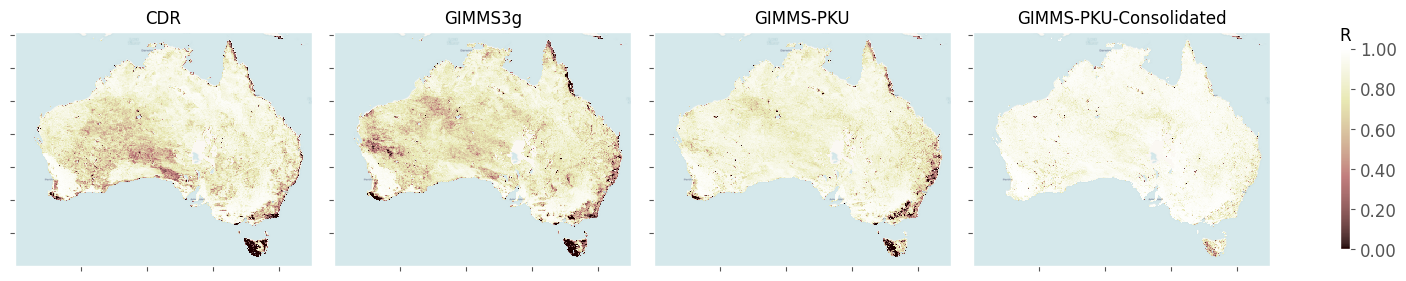

In [16]:
corr_data = [cdr_corr,corr_gimms,corr_pku, corr_pku_cons] 
products=['CDR', 'GIMMS3g','GIMMS-PKU','GIMMS-PKU-Consolidated'] 

fig,axes = plt.subplots(1,4, figsize=(18,4), sharey=True)

for ax, ds, n in zip(axes.ravel(), corr_data, products):
    if n=='Difference':
        cmap='RdBu'
        vmin=-0.5
        vmax=0.5
    else:
        cmap='pink'
        vmin=0
        vmax=1
    im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.set_title(f'{n}', fontsize=12)
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])

plt.subplots_adjust(wspace=0.075)
cbar = fig.colorbar(im, location='right', ax=axes.ravel().tolist(), fraction=0.05, shrink=0.65)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
cbar.ax.set_title('R', fontsize=12)
# cbar.set_label(label=var+' PgC/year', size=15, weight='bold')
cbar.ax.tick_params(labelsize=12)
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compareallproducts_correlation_perpixel.png',
            bbox_inches='tight', dpi=300);

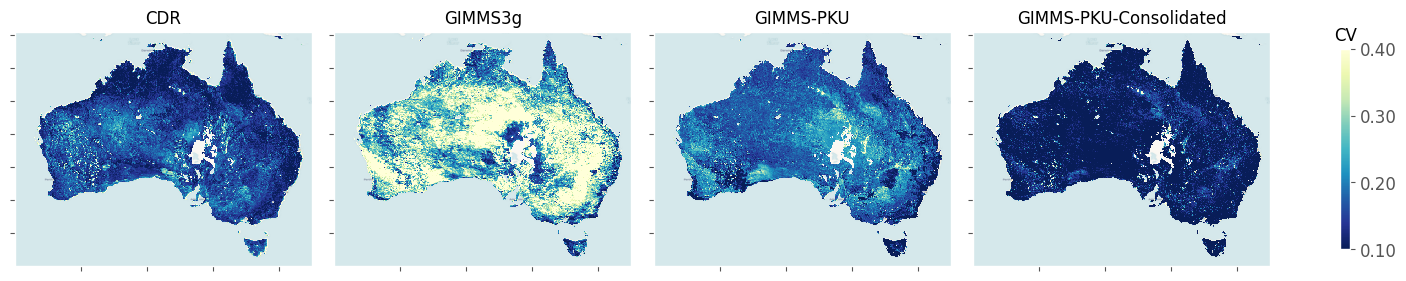

In [17]:
corr_data = [cdr_rmse, rmse_gimms,rmse_pku, rmse_pku_cons] 
products=['CDR','GIMMS3g','GIMMS-PKU', 'GIMMS-PKU-Consolidated'] 

fig,axes = plt.subplots(1,4, figsize=(18,4), sharey=True)

for ax, ds, n in zip(axes.ravel(), corr_data, products):
    if model_var=='NDVI':
        if n=='Difference':
            cmap='RdBu'
            vmin=-0.1
            vmax=0.1
        else:
            cmap='YlGnBu_r'
            vmin=0.1
            vmax=0.4
    
    if model_var=='LST':
        if n=='Difference':
            cmap='RdBu'
            vmin=-6
            vmax=6
        else:
            cmap='cividis'
            vmin=0
            vmax=7.0
    im = (ds/modis_mean).plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)   
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f'{n}', fontsize=12)
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.subplots_adjust(wspace=0.075)
cbar = fig.colorbar(im, location='right', ax=axes.ravel().tolist(), fraction=0.05, shrink=0.65)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
cbar.ax.set_title('CV', fontsize=12)
# cbar.set_label(label=var+' PgC/year', size=15, weight='bold')
cbar.ax.tick_params(labelsize=12)
fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compareallproducts_CV_perpixel.png',
            bbox_inches='tight', dpi=300);

## Residuals through time



In [18]:
# #residuals after harmonization
# residual = (modis - merge).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='After harmonization')
# residual_sd = (modis - merge).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='After harmonization')

# residual_pku = (modis - gimms_pku).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='GIMMS-PKU')
# residual_sd_pku = (modis - gimms_pku).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='GIMMS-PKU')

# residual_gimms = (modis - gimms).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='GIMMS3g')
# residual_sd_gimms = (modis - gimms).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='GIMMS3g')

# # residuals before harmonization
# residual_b = (modis - avhrr).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='CDR')
# residual_sd_b = (modis - avhrr).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='CDR')

In [19]:
# fig,ax = plt.subplots(1,1, figsize=(12,4), sharex=True)

# residual_b.plot(ax=ax, legend=False, color='red')
# residual_pku.plot(ax=ax, legend=False, color='blue')
# residual_gimms.plot(ax=ax, legend=False, color='forestgreen')

# ax.axhline(0.0, color='k', linestyle='--')
# ax.legend(loc='upper left')
# ax.set_title('Average Residuals with MODIS')
# ax.set_ylim(-0.125, 0.125)
# ax.set_ylabel(model_var+" $_{MODIS}$"+ " - "+model_var+"$_{AVHRR}$", fontsize=13)
# ax.set_xlabel(None)
# ax.tick_params(axis='y', labelsize=12)
# ax.tick_params(axis='x', labelsize=12)

# plt.tight_layout()
# fig.savefig(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/{model_var}_compare_residuals.png',
#             bbox_inches='tight', dpi=300);

## Anomalies against Landsat

In [20]:
cdr = xr.open_dataset(base+model_var+'_harmonization/AVHRR_'+model_var+'_5km_monthly_1982_2013.nc')[model_var+'_avhrr']
cdr = assign_crs(cdr, crs=crs)
cdr.attrs['nodata'] = np.nan
cdr = cdr.rename('NDVI')

pku = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS-PKU_1982_2013.nc').rename({'__xarray_dataarray_variable__':'NDVI'})['NDVI']
pku = assign_crs(pku, crs=crs)
pku.attrs['nodata'] = np.nan

pku_cons = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS-PKU-MODIS_1982_2022.nc').rename({'__xarray_dataarray_variable__':'NDVI'})['NDVI']
pku_cons = pku_cons.sel(time=slice('1982','2013'))
pku_cons = assign_crs(pku_cons, crs=crs)
pku_cons.attrs['nodata'] = np.nan

gimms = xr.open_dataset(base+model_var+'_harmonization/AVHRR_GIMMS3g_v1.1_1982_2013.nc')['NDVI']
gimms = assign_crs(gimms, crs='epsg:3577')
gimms.attrs['nodata'] = np.nan

ls = xr.open_dataset(base+'/NDVI_harmonization/Landsat_NDVI_5km_monthly_1988_2012.nc')['NDVI']
ls = assign_crs(ls, crs=crs)
ls.attrs['nodata'] = np.nan

rain = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_2022.nc').rain
rain = assign_crs(rain, crs=crs)
rain.attrs['nodata'] = np.nan

### Match datasets

In [21]:
pku = pku.sel(time=ls.time)
pku_cons = pku_cons.sel(time=ls.time)
gimms = gimms.sel(time=ls.time)
rain = rain.sel(time=ls.time)
cdr = cdr.sel(time=ls.time)

ls = ls.odc.reproject(pku.odc.geobox, resampling='average')
cdr = cdr.odc.reproject(pku.odc.geobox, resampling='average')
gimms = gimms.odc.reproject(pku.odc.geobox, resampling='nearest')
pku_cons = pku_cons.odc.reproject(pku.odc.geobox, resampling='nearest')
rain = rain.odc.reproject(pku.odc.geobox, resampling='average')

ls = round_coords(ls)
pku = round_coords(pku)
pku_cons = round_coords(pku_cons)
rain = round_coords(rain)
cdr = round_coords(cdr)
gimms = round_coords(gimms)

In [22]:
gimms_mask =  ~np.isnan(gimms)
del gimms_mask.attrs['nodata']
gimms_mask = assign_crs(gimms_mask, crs=crs)

cdr_mask =  ~np.isnan(cdr)
del cdr_mask.attrs['nodata']
cdr_mask = assign_crs(cdr_mask, crs=crs)

pku_mask =  ~np.isnan(pku)
del pku_mask.attrs['nodata']
pku_mask = assign_crs(pku_mask, crs=crs)

pku_cons_mask =  ~np.isnan(pku_cons)
del pku_cons_mask.attrs['nodata']
pku_cons_mask = assign_crs(pku_cons_mask, crs=crs)

ls_mask =  ~np.isnan(ls)
del ls_mask.attrs['nodata']
ls_mask = assign_crs(ls_mask, crs=crs)

#combine masks
mask = (gimms_mask & pku_mask & pku_cons_mask & ls_mask & cdr_mask)
# mask = (pku_mask & ls_mask)

In [23]:
pku = pku.where(mask)
pku_cons = pku_cons.where(mask)
gimms = gimms.where(mask)
rain = rain.where(mask)
cdr = cdr.where(mask)
ls = ls.where(mask)

cdr = cdr.rename({'latitude':'y', 'longitude':'x'})
pku = pku.rename({'latitude':'y', 'longitude':'x'})
pku_cons = pku_cons.rename({'latitude':'y', 'longitude':'x'})
ls = ls.rename({'latitude':'y', 'longitude':'x'})
rain = rain.rename({'latitude':'y', 'longitude':'x'})
gimms = gimms.rename({'latitude':'y', 'longitude':'x'})

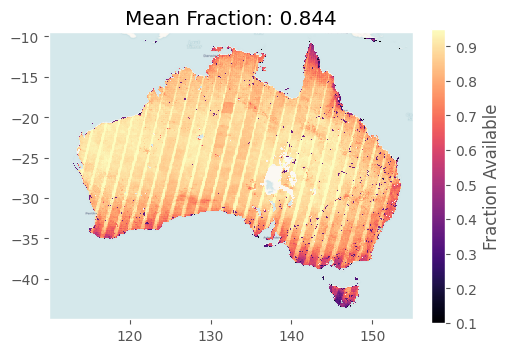

In [24]:
fraction_avail= (~np.isnan(pku)).sum('time')/len(pku.time)

fig,ax=plt.subplots(1,1, figsize=(5,4),sharey=True, layout='constrained')

im = fraction_avail.where(fraction_avail>0).rename('').plot(vmin=0.1, vmax=0.95, ax=ax, cmap='magma', add_labels=False, add_colorbar=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)

cb = fig.colorbar(im, ax=ax, shrink=0.75, orientation='vertical', label='Fraction Available');
ax.set_title('Mean Fraction: '+str(round(fraction_avail.where(fraction_avail>0).mean().values.item(), 3)));

### Calculate standardised anomalies

In [25]:
import warnings
warnings.simplefilter('ignore')

#standardized anom
def stand_anomalies(ds):
    return xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
            ds.groupby("time.month"),
            ds.sel(time=slice('1988', '2012')).groupby("time.month").mean(),
            ds.sel(time=slice('1988', '2012')).groupby("time.month").std()
    )
    
rain_std_anom = stand_anomalies(rain)
pku_std_anom = stand_anomalies(pku)
pku_cons_std_anom = stand_anomalies(pku_cons)
gimms_std_anom = stand_anomalies(gimms)
ls_std_anom = stand_anomalies(ls)
cdr_std_anom = stand_anomalies(cdr)

### Rolling mean anomalies

In [26]:
roll=12

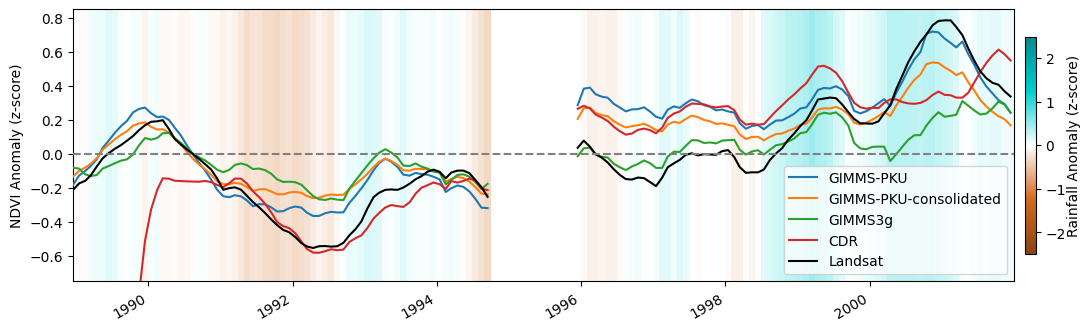

In [29]:
rain_df = rain_std_anom.rename('rain').mean(['x','y']).rolling(time=roll,
                min_periods=roll).mean().sel(time=slice('1989','2001')).to_dataframe().drop(['spatial_ref', 'month'], axis=1)

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(14,4))
ax2 = ax.twinx()
#.sel(time=slice('1988','2001'))
pku_std_anom.drop('month').sel(time=slice('1988','2001')).mean(['x','y']).rolling(time=roll, min_periods=roll).mean().plot(ax=ax, label='GIMMS-PKU')
pku_cons_std_anom.drop('month').sel(time=slice('1988','2001')).mean(['x','y']).rolling(time=roll, min_periods=roll).mean().plot(ax=ax, label='GIMMS-PKU-consolidated')
gimms_std_anom.drop('month').sel(time=slice('1988','2001')).mean(['x','y']).rolling(time=roll, min_periods=roll).mean().plot(ax=ax, label='GIMMS3g')
cdr_std_anom.drop('month').sel(time=slice('1988','2001')).mean(['x','y']).rolling(time=roll, min_periods=roll).mean().plot(ax=ax, label='CDR')
ls_std_anom.drop('month').sel(time=slice('1988','2001')).mean(['x','y']).rolling(time=roll, min_periods=roll).mean().plot(ax=ax, label='Landsat', color='black')

norm=plt.Normalize(-2.5,2.5)
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['saddlebrown','chocolate','white','darkturquoise','darkcyan'], N=256)

# Plot bars
bar = ax2.bar(rain_df.index, 1, color=cmap(norm(rain_df['rain'])), width=32)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8, pad=0.01)
cbar.set_label('Rainfall Anomaly (z-score)',labelpad=.5)

ax2.set_zorder(ax.get_zorder()-1)
ax.set_frame_on(False)
ax.axhline(0, c='grey', linestyle='--')

# Reformat y-axis label and tick labels
ax.set_ylabel(model_var+' Anomaly (z-score)')
ax.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_ylim([0, 1]) 
ax.set_ylim([-0.75, 0.85]) 
ax.margins(x=0)
ax2.margins(x=0)

# Adjust the margins around the plot area
plt.subplots_adjust(left=0.1, right=None, top=None, bottom=0.2, wspace=None, hspace=None)
ax.legend()
ax.set_title(None);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/Australian_NDVI_compareall_anomalies_landsat_"+str(roll)+"Mrollingmean.png",
            bbox_inches='tight', dpi=300)